In [1]:
#REFRENCES
# https://www.youtube.com/watch?v=ijaT8HuCtIY (MNIST classification using PyTorch)
# https://www.youtube.com/watch?v=gBw0u_5u0qU
# getting the random test image from the MNIST dataset has some sort of refrencing from AI

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np

# loading the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = MNIST(root='./data', train=True, transform=transform, download=True)
mnist_test = MNIST(root='./data', train=False, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)

# given model with pre-defined weights
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.features(x)
        return x

# loading the pre-trained feature extractor
feature_extractor = FeatureExtractor()
feature_extractor.load_state_dict(torch.load('feature_extractor.pth', map_location=torch.device('cpu')))
feature_extractor.eval()

# multi-task model defined
class MultiTaskModel(nn.Module):
    def __init__(self, feature_extractor):
        super(MultiTaskModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.digit_classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),  # Adjust input size based on your FeatureExtractor's output size
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        self.binary_classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),  # Adjust input size based on your FeatureExtractor's output size
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)
        digit_logits = self.digit_classifier(features)
        binary_logits = self.binary_classifier(features)
        return digit_logits, binary_logits

# loss function applied
digit_loss_fn = nn.CrossEntropyLoss()
binary_loss_fn = nn.BCEWithLogitsLoss()

# initialize the multi-task model
model = MultiTaskModel(feature_extractor)

# adam optimizer used for training neural netwok with the defined learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the images with the digit and binary labels
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        optimizer.zero_grad()
        digit_logits, binary_logits = model(images)
        digit_loss = digit_loss_fn(digit_logits, labels)
        binary_labels = (labels > 5).float()  # 1 if digit > 5, else 0
        binary_loss = binary_loss_fn(binary_logits.view(-1), binary_labels)
        total_loss = digit_loss + binary_loss
        total_loss.backward()
        optimizer.step()







100%|██████████| 9912422/9912422 [00:00<00:00, 87854446.73it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 73415572.01it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 20682730.42it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15955216.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
# evaluation of the model
model.eval()
digit_correct = 0
binary_correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        digit_logits, binary_logits = model(images)
        _, digit_predicted = torch.max(digit_logits.data, 1)
        binary_predicted = (binary_logits > 0).float()
        total += labels.size(0)
        digit_correct += (digit_predicted == labels).sum().item()
        binary_correct += (binary_predicted.flatten() == (labels > 5).float()).sum().item()
digit_accuracy = digit_correct / total
binary_accuracy = binary_correct / total

print(f"Digit Classification Accuracy: {digit_accuracy * 100:.2f}%")
print(f"Binary Classification Accuracy: {binary_accuracy * 100:.2f}%")

Digit Classification Accuracy: 99.10%
Binary Classification Accuracy: 99.42%


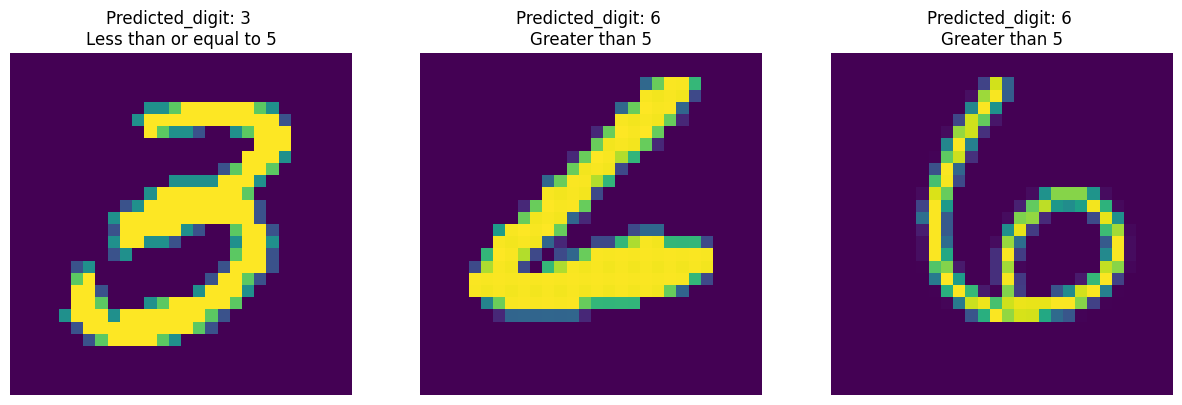

In [10]:
import random
import matplotlib.pyplot as plt

sample_data = []
sample_label = []
predicted_label_binary = []
predicted_label_digit = []

for images, labels in test_loader:
  sample_data.append(images[0])
  sample_label.append(labels[0])

# taking the three random indices
random_indices = random.sample(range(len(sample_data)), 3)


random_sample = [sample_data[i] for i in random_indices]
random_labels = [sample_label[i] for i in random_indices]

for image in random_sample:
  # makes the prediction
  with torch.no_grad():
    digit_logits, binary_logits = model(torch.unsqueeze(image, 0))

  # converting the logits into class labels
  _, digit_predicted = torch.max(digit_logits.data, 1)
  binary_predicted = (binary_logits > 0).float()
  predicted_label_binary += binary_predicted
  predicted_label_digit += digit_predicted

sample = random_sample[1].numpy()

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Iterate through the images and labels
for i, image  in enumerate(random_sample):
    # Load the image
    image = image.numpy()

    # Display the image on the current subplot
    axs[i].imshow(image.squeeze())
    axs[i].axis('off')  # Turn off axis labels for the image

    # Display true and predicted labels as the title of the current subplot
    axs[i].set_title(f"Predicted_digit: {predicted_label_digit[i]} \n{'Greater than 5' if predicted_label_binary[i][0] == 1 else 'Less than or equal to 5'}")

# Show the plot
plt.show()







